# Author Identification Problem
    
Student: Filip Vuković <br>
University: Undergraduate university study programme in Mathematics and Computer Science, Osijek, Croatia <br>
    
## Problem

Identify who of the three authors, *Edgar Allan Poe (EAP), Mary Wollstonecraft Shelley (MWS)* or *HP LoveCraft (HPL)*, is the author of a given quote <br>
more information on <a href="https://www.kaggle.com/c/spooky-author-identification">Kaggle</a>

## 1. Solution 1 (using Nativ Languge Processing)
### 1.1 Idea
   - Load datasets
   - Remove punctuation and stopwords
   - Convert words into matching root forms
   - Create *Bag of Words*
   - Use *MultinomialNB classifier* to train data

    

We begin by importing a bunch of useful functions and python libraries.

In [1]:
import pandas # for loading csv files
import string # for string manipulation
import matplotlib.pyplot as plt # display data
from nltk.corpus import stopwords # stopwords are words that do not add much meaning to a sentence
from nltk.stem import WordNetLemmatizer # for word conversion into matching root forms
from sklearn.feature_extraction.text import CountVectorizer # transforms documents to feature vectors
from sklearn.naive_bayes import MultinomialNB # Naive Bayes classifier
from sklearn.model_selection import train_test_split # split training data for testing

Next, we define a function that processes given text as follows: First we remove punctuation and convert every word into its root form. Lastly we remove stop-words and return a list.

In [2]:
def processText(text):
    
    # punctuation removal
    text = ''.join(c for c in text if c not in string.punctuation)
    
    # lemmatisation on verbs, nouns and adjectives
    lemmatiser = WordNetLemmatizer() # converts words into root forms
    
    final, step1, step2, lemmahelp = '', '', '', ''
    
    for i in range(len(text.split())): # split by ' '
        lemmahelp = lemmatiser.lemmatize(text.split()[i], pos = 'v') 
        step1 += lemmahelp + ' '
   
    for i in range(len(step1.split())): # split by ' '
        lemmahelp = lemmatiser.lemmatize(step1.split()[i], pos = 'n') 
        step2 += lemmahelp + ' '
    
    for i in range(len(step2.split())): # split by ' '
        lemmahelp = lemmatiser.lemmatize(step2.split()[i], pos = 'a') 
        final += lemmahelp + ' '
        
    # stopwords removal
    return [w for w in final.split() if w.lower() not in stopwords.words('english')]


Then we use pandas to load *.csv* files that contain our datasets. 

In [3]:
# please adjust PATHs to train.csv and test.csv
from pathlib import Path # Path() method will convert forward slashes into the correct kind of slash for the current os
myPath = Path("C:/Users/Filip/Documents/Praksa/spooky-author-identification/")
trainSet = pandas.read_csv(myPath / "train.csv")
testSet = pandas.read_csv(myPath / "test.csv")

trainSet.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


Once we load our data we need to make sure that it is balanced. That means that datasets are distributed equaly. In this case, approximately equal number of EAP, HP and MWS quotes.

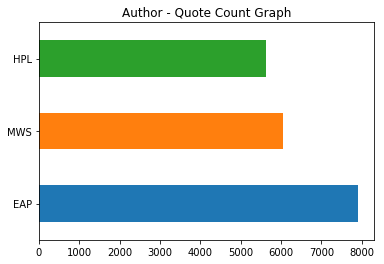

In [4]:
X = trainSet['text']
y = trainSet['author']

y.value_counts().plot(kind = 'barh', title = 'Author - Quote Count Graph')

From this graph we can see that our data is pretty balanced which means we don't have to fix anything. <br>
Let's continue with splitting training data into learning data and testing data (taking 15% as testing data).

In [5]:
# stratify strategy to balance the train set is implemented by default
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 27381)

### 1.2 Bag of Words
We use *Bag of Words* representation because the raw data, a sequence of symbols, cannot be fed directly into the learning algorithms themselves as most of them expect numbers or some form of numerical values. In order to create numerical feature vectors we use *vectorization*.

Let's create *Bag of Words* for training and testing data

In [6]:
# we use fit(), once, to calculate, and transform() to apply the transformation to any particular set

vectorizer = CountVectorizer(analyzer = processText).fit(X_train)

bag_of_words_train = vectorizer.transform(X_train) 
bag_of_words_test = vectorizer.transform(X_test)  # for accuracy calculation

toTest = vectorizer.transform(testSet['text']) # for later

### 1.3 Training

Now we can train the *Multinomial Naive Bayes* classifier. *Naive Bayes* classifiers are a family of simple "probabilistic classifiers" based on applying *Bayes' theorem* with strong independence assumptions between the features

In [7]:
MNBmodel = MultinomialNB().fit(bag_of_words_train, y_train)

### 1.4 Accuracy
We are working with balanced dataset so we can use *.score* function to calculate training and testing accuracy.

In [8]:
trainScore = MNBmodel.score(bag_of_words_train, y_train)
trainScore

0.9032568200937388

In [9]:
testScore = MNBmodel.score(bag_of_words_test, y_test)
testScore

0.8399727613210759

As shown above training accuracy is over 90% while testing accuracy is at 84%, making this overall an acceptable accuracy. <br>
Let's see what results we can get using more sophisticated methods for accuracy computation. We will use *F1, recall, precision* and *log loss* tehniques.

In [10]:
from sklearn.metrics import classification_report

MNBpredictions = MNBmodel.predict(bag_of_words_test)
print(classification_report(y_test, MNBpredictions))

              precision    recall  f1-score   support

         EAP       0.86      0.82      0.84      1192
         HPL       0.85      0.83      0.84       843
         MWS       0.80      0.88      0.84       902

   micro avg       0.84      0.84      0.84      2937
   macro avg       0.84      0.84      0.84      2937
weighted avg       0.84      0.84      0.84      2937



Due to the fact that we have balanced dataset, our accuracy is on average the same as with *score* function. <br>
The last tehnique is used, by <a href="https://www.kaggle.com/c/spooky-author-identification"> Kaggle</a>, to evalute this particular problem.

Now, let's check *Logarithic Loss* measurements

In [11]:
from sklearn.metrics import log_loss
prediction = MNBmodel.predict_proba(bag_of_words_test)
log_loss(y_test, prediction)

0.4422914439323845

We should not be satisfied with this result because Logarithic Loss measures the performace of a classifier where the prediction input is a probability value in range [0, 1]. The goal is to minimize this values, a better classifier would have that value closer to 0.

### 1.5 Predicting
This is where all the fun begins. We can now predict authors of vectorized text snipps from our test dataset

In [12]:
for i in range(5):
    print(list(map(max,(MNBmodel.predict_proba(toTest[i]).round(4)))), MNBmodel.predict(toTest[i]))

[0.9993] ['MWS']
[0.9999] ['EAP']
[0.893] ['HPL']
[0.8978] ['HPL']
[0.9814] ['EAP']


As shown above, classifier certainty is 89% at minimum for first 5 examples in test dataset <br>
Let's try to predict some random sentence

In [13]:
sentence = ["Luke, I''m your father!"]
sentence = vectorizer.transform(sentence)
print(MNBmodel.predict_proba(sentence). round(2), MNBmodel.predict(sentence))

[[0.14 0.63 0.24]] ['HPL']


In other words, 63% certainty for HPL (14% for EAP and 24% for MWS)

## 2. Solution 2 (using Linear SVC or Support Vector Classification) 

Once again we first import LinearSVC then we can train it, since we have
already prepared data and calculated everything we need.

In [14]:
from sklearn.svm import LinearSVC

### 2.1 Training
Let's train *LinearSVC* classifier. *LinearSVC* uses linear combinations of features for statistic classification.

In [15]:
LSVCmodel = LinearSVC().fit(bag_of_words_train, y_train)

### 2.2 Accuracy
We will compute accuracy just like we did with previous model

In [16]:
LSVC_train_score = LSVCmodel.score(bag_of_words_train, y_train)
LSVC_train_score

0.9881624804710972

In [17]:
LSVC_test_score = LSVCmodel.score(bag_of_words_test, y_test)
LSVC_test_score

0.7980932924753149

As you can see, using *LinearSVC* model we actually lost about 4% in testing accuracy but gain 8% in training accuracy which is very interesting. Now, we calculate precision, recall and F1 scores.

In [18]:
LSVCpredictions = LSVCmodel.predict(bag_of_words_test)
print(classification_report(y_test, LSVCpredictions))

              precision    recall  f1-score   support

         EAP       0.80      0.82      0.81      1192
         HPL       0.82      0.79      0.80       843
         MWS       0.78      0.78      0.78       902

   micro avg       0.80      0.80      0.80      2937
   macro avg       0.80      0.80      0.80      2937
weighted avg       0.80      0.80      0.80      2937



On average, just like when using *.score* method, we have a 4% loss in accuracy. Note that the precision and recall are quite low. Let's make some predictions and observe obvious differences.

### 2.3 Predicting

Remember *toTest* is vectorized test dataset and *sentence* is "Luke, I''m your father".

In [19]:
for i in range(5):
    print(LSVCmodel.predict(toTest[i]))

['MWS']
['HPL']
['HPL']
['EAP']
['EAP']


In [20]:
print(LSVCmodel.predict(sentence))

['HPL']


Only 3 out of 5 predictions match predictions made by Multinomial Naive Bayes classifier. However, it predicted the same output for our random sentence. <br>

## 3. Comparison (LinearSVC vs. MultinomialNB)
Let's see how many different predictions are there.

In [21]:
count = 0
for i in range(toTest.shape[0]):
    if LSVCmodel.predict(toTest[i]) != MNBmodel.predict(toTest[i]):
        count += 1
count / toTest.shape[0]

0.17373689227836034

As you can see, 17% of all test predictions are different when comparing *LinearSVC* and *MultinomialNB classifiers*. So which classifier is more sutable for this problem? Of course, it is *MultinomialNB* because the testing data had greater accuracy.

## 4. Solution 3 (using Decision Tree Classifier)
*Decision Tree Classifier* is a Supervised Machine Learning tehnique where the data is continuously split according to a certain parameter. <br>
Of course, we have to import *DecisionTreeClassifier* in order to train it.

In [22]:
from sklearn.tree import DecisionTreeClassifier

### 4.1 Training
We already prepared data so we can just train *DecisionTreeClassifier*

In [23]:
DTCmodel = DecisionTreeClassifier().fit(bag_of_words_train, y_train)

### 4.2 Accuracy
Let's calculate accuracy of our model.

In [24]:
DTC_train_score = DTCmodel.score(bag_of_words_train, y_train)
DTC_train_score

0.999699555341906

In [25]:
DTC_test_score = DTCmodel.score(bag_of_words_test, y_test)
DTC_test_score

0.6081035069799114

In [26]:
DTCpredictions = DTCmodel.predict(bag_of_words_test)
print(classification_report(y_test, DTCpredictions))

              precision    recall  f1-score   support

         EAP       0.65      0.65      0.65      1192
         HPL       0.58      0.56      0.57       843
         MWS       0.58      0.61      0.59       902

   micro avg       0.61      0.61      0.61      2937
   macro avg       0.60      0.60      0.60      2937
weighted avg       0.61      0.61      0.61      2937



As you can see from the results above, using DecisionTreeClassifier to solve this particular problem is a bad idea because it's
only 61% accurate. However, it has almost perfect accuracy when predicting training data, more then any other classifier we tried so far.
### 4.3 Predicting
Although, this model did not satisfy. We will take a look at its predictions. 

In [27]:
for i in range(5):
    print(DTCmodel.predict(toTest[i]))

['MWS']
['MWS']
['HPL']
['MWS']
['EAP']


In [28]:
print(DTCmodel.predict(sentence))

['MWS']


## 5. Solution 4 (using Random Forest Classifier)
*Random Forest Classifier* is a meta estimator that fits a number of *decision tree classifiers* on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. <br>
Let's import *RandomForestClassifier* and train it.

In [29]:
from sklearn.ensemble import RandomForestClassifier

### 5.1 Training

In [30]:
RFCmodel = RandomForestClassifier(n_estimators=200).fit(bag_of_words_train, y_train) # 200 trees in the forestb

### 5.2 Accuracy
We will calculate the accuracy of this model just like the previous ones.

In [31]:
RFC_train_score = RFCmodel.score(bag_of_words_train, y_train)
RFC_train_score

0.999699555341906

In [32]:
RFC_test_score = RFCmodel.score(bag_of_words_test, y_test)
RFC_test_score

0.7361252979230507

In [33]:
RFCpredictions = RFCmodel.predict(bag_of_words_test)
print(classification_report(y_test, RFCpredictions))

              precision    recall  f1-score   support

         EAP       0.72      0.80      0.76      1192
         HPL       0.79      0.64      0.71       843
         MWS       0.73      0.74      0.73       902

   micro avg       0.74      0.74      0.74      2937
   macro avg       0.74      0.73      0.73      2937
weighted avg       0.74      0.74      0.73      2937



Since *Random Forest Classifier* works with multiple *Decision Tree Classifiers* it's not uncommon that the training data accuracy is pretty much the same. But the testing data accuracy is 10% higher making this model a much better choice.

### 5.3 Prediciting
As usual we will predict first 5 quotes in test dataset and one random sentance

In [34]:
for i in range(5):
    print(list(map(max,(RFCmodel.predict_proba(toTest[i]).round(4)))), RFCmodel.predict(toTest[i]))

[0.865] ['MWS']
[0.37] ['EAP']
[0.615] ['HPL']
[0.435] ['MWS']
[0.8179] ['EAP']


In [35]:
print(list(map(max,(RFCmodel.predict_proba(sentence).round(4)))), RFCmodel.predict(sentence))

[0.755] ['MWS']


## 6. Comparison (DecisionTree vs RandomForest)
I'm curious what are the prediction differences between DecisionTreeClassifier and RandomForestClassier

In [36]:
count = 0
for i in range(toTest.shape[0]):
    if RFCmodel.predict(toTest[i]) != DTCmodel.predict(toTest[i]):
        count += 1
count / toTest.shape[0]

0.2651334604385129

27% is a big difference.

## 7. Solution 5 (using Support Vector Machines - with linear, RBF and polinominal kernel)
Support vector machines are a set of supervised learining methods used for classification, regression and outliers detection.
### 7.1 Idea
Since every model has its own parameters, first we have to choose the optimal one with the best hypothesis or function inside that particular model. In order to find optimal model we will use a technique called *GridSearch cross-validation*. <br>
This time we will divide our training dataset into 3 subsets: 1. training, 2. validation, 3. testing. As always, we use training subset to train models but this time we will train them multiple times, using *GridSearchCV*, with different parameters in order to get optimal parameters for each model. <br>
Once we've done that, we select the best model. <br>
Now, we can train that selected model again on training and validation subsets, with optimal parameters we got before. Then we test it using testing subset. <br>
Once that is finished, we train our model on train dataset from the beginning and make predictions on test dataset.

Importing needed libraries

In [37]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

Next, we divide training dataset. We will take 75% for training, 15% for validation and 10% for testing.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 12412)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size = 0.1/(0.1+0.15), random_state = 44815)

We can not possibly work with string. So one again we have to vectorize our datasets.

In [39]:
vectorizer = CountVectorizer(analyzer = processText).fit(X_train)

bag_of_words_train = vectorizer.transform(X_train) 
bag_of_words_validation = vectorizer.transform(X_validation) 
bag_of_words_test = vectorizer.transform(X_test)

### 7.2 Searching for optimal parameters
Let's use *GridSearchCV* to generate optimal parametars

In [40]:
import multiprocessing
maxJobs = multiprocessing.cpu_count()

In [41]:
SVCmodel = svm.SVC()

parameters = {
    'kernel' : ['linear'],
    'C': [0.1, 1, 10, 100, 1000]
}

linearGrid = GridSearchCV(estimator = SVCmodel,
                      param_grid = parameters,
                      scoring = 'accuracy',
                      cv = 5,
                      n_jobs = maxJobs) # using all local processors

linearGrid.fit(bag_of_words_train, y_train)
print(linearGrid.best_estimator_)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


In [42]:
print(linearGrid.score(bag_of_words_validation, y_validation))

0.7749404153898536


In [43]:
parameters = {
    'kernel' : ['rbf'],
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001]
}

rbfGrid = GridSearchCV(estimator = SVCmodel,
                      param_grid = parameters,
                      scoring = 'accuracy',
                      cv = 5,
                      n_jobs = maxJobs)

rbfGrid.fit(bag_of_words_train, y_train)
print(rbfGrid.best_estimator_)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [44]:
print(rbfGrid.score(bag_of_words_validation, y_validation))

0.7824310520939735


In [45]:
parameters = {
    'kernel' : ['poly'],
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001]
}

polyGrid = GridSearchCV(estimator = SVCmodel,
                      param_grid = parameters,
                      scoring = 'accuracy',
                      cv = 5,
                      n_jobs = maxJobs)

polyGrid.fit(bag_of_words_train, y_train)
print(polyGrid.best_estimator_)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [46]:
print(polyGrid.score(bag_of_words_validation, y_validation))

0.5236636023152877


We now clearly select SVC with RBF kernel because it has the best accuracy score of 78%. <br>
### 7.3 Preparing datasets
So let's join training and validation datasets in order to train our model again but with optimal parameters.

In [47]:
X_train.append(X_validation)
y_train.append(y_validation);

In [48]:
RBFmodel = svm.SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [49]:
vectorizer = CountVectorizer(analyzer = processText).fit(X_train)
bag_of_words_train_rbf = vectorizer.transform(X_train) 

### 7.4 Training and accuracy computation
Now that we prepared our datasets. We train our model, test it and see accuracy scores.

In [50]:
RBFmodel.fit(bag_of_words_train_rbf, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [51]:
RBFpredictions = RBFmodel.predict(bag_of_words_test)
print(classification_report(y_test, RBFpredictions))

              precision    recall  f1-score   support

         EAP       0.72      0.86      0.79       760
         HPL       0.86      0.72      0.78       623
         MWS       0.80      0.74      0.77       575

   micro avg       0.78      0.78      0.78      1958
   macro avg       0.80      0.77      0.78      1958
weighted avg       0.79      0.78      0.78      1958



We got pretty solid accuracy of 78/79%. 

## 8. Conclusion 
We created, trained and tested a bunch of different classifiers and used accuracy scores to determine the best one. The *Multinomial Naive Bayes* classifier had the highest accuracy score therefore it is the best choice. <br>
Next thing we could do is train that classifier again on our training dataset, make predictions on testing dataset and save them in *.csv* files. One solution and the other for submission to Kaggle.

In [52]:
finalVectorizer = CountVectorizer(analyzer = processText).fit(X) 
finalBag = finalVectorizer.transform(X)
finalModel = MultinomialNB().fit(finalBag, y)
finalTest = finalVectorizer.transform(testSet['text'])

Let's create *solution.csv* and *submission.csv* files

In [53]:
finalPredicions = finalModel.predict(finalTest)

In [54]:
solution = pandas.DataFrame({'Quote': testSet['text'], 'Predicted author': finalPredicions})

solution.to_csv('solution.csv',index=False, encoding='utf-8')

In [55]:
finalProbas = finalModel.predict_proba(finalTest)

In [56]:
EAP = finalProbas[:,0]
HPL = finalProbas[:,1]
MWS = finalProbas[:,2]

In [57]:
submission = pandas.DataFrame({'id':testSet['id'], 'EAP':EAP, 'HPL':HPL, 'MWS':MWS})

submission.to_csv('submission.csv',index=False, encoding='utf-8')

After submitting the file to Kaggle. 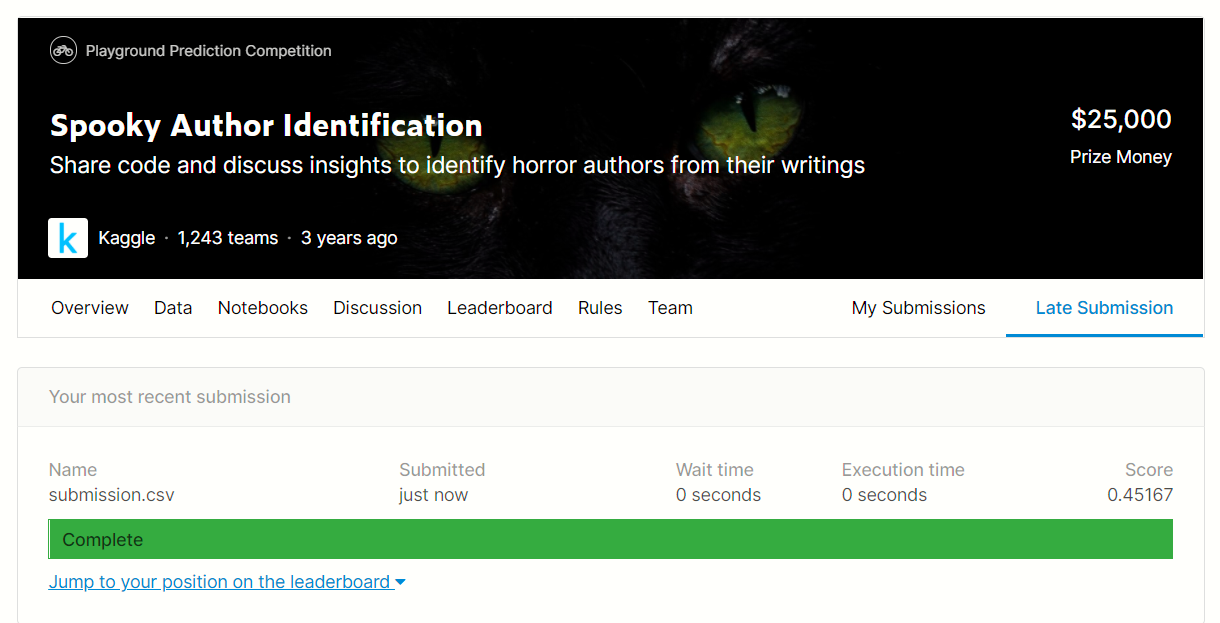 <br>
We got 0.45 score. Since Kaggle evaluates results using *log loss* tehnique, this is a good result.

At the end. We deploy our final model as web service. <br>
## 9. Web service
We deploy our model and vectorizer in order to use them in our web service as an example of how we can use these trained models.

In [58]:
from sklearn.externals import joblib

joblib.dump(finalModel, 'model.pkl')

['model.pkl']

In [59]:
import pickle

pickle.dump(finalVectorizer, open('vectorizer.pkl', 'wb'))

Next, we create web service using python library - flask.

In [60]:
import flask
import os
import pickle
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.externals import joblib

app = flask.Flask(__name__)
port = int(os.getenv("PORT", 9090))

def processText(text):
    
    # punctuation removal
    text = ''.join(c for c in text if c not in string.punctuation)
    
    # lemmatisation on verbs, nouns and adjectives
    lemmatiser = WordNetLemmatizer() # converts words into root forms
    
    final, step1, step2, lemmahelp = '', '', '', ''
    
    for i in range(len(text.split())): # split by ' '
        lemmahelp = lemmatiser.lemmatize(text.split()[i], pos = 'v') 
        step1 += lemmahelp + ' '
   
    for i in range(len(step1.split())): # split by ' '
        lemmahelp = lemmatiser.lemmatize(step1.split()[i], pos = 'n') 
        step2 += lemmahelp + ' '
    
    for i in range(len(step2.split())): # split by ' '
        lemmahelp = lemmatiser.lemmatize(step2.split()[i], pos = 'a') 
        final += lemmahelp + ' '
        
    # stopwords removal
    return [w for w in final.split() if w.lower() not in stopwords.words('english')]

model = joblib.load(open("model.pkl", "rb"))
vectorizer = pickle.load(open("vectorizer.pkl", "rb"))

@app.route('/', methods=['GET'])
def hello():
   return "Hello world!"

@app.route('/predict', methods=['POST'])
def predict():
    quote = flask.request.get_json(force=True)['quote']
    print("quote = ", quote)
    quote = vectorizer.transform([quote])

    prediction = model.predict(quote)
    print(prediction)
    return flask.jsonify(prediction[0])

After running our app, we use the following command in Windows PowerShell to test quotes:<br>
*Invoke-RestMethod -Method POST -Uri http://localhost:9090/predict -Body '{"quote":"Type A Quote Here"}'* <br>
We can stop the following cell by pressing -i- twice.

In [61]:
app.run(host='127.0.0.1', port=port)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:9090/ (Press CTRL+C to quit)
127.0.0.1 - - [18/Aug/2020 03:04:26] "POST /predict HTTP/1.1" 200 -


quote =  The visits of Merrival to Windsor, before frequent, had suddenly ceased.
['MWS']


127.0.0.1 - - [18/Aug/2020 03:04:30] "POST /predict HTTP/1.1" 200 -


quote =  Their operation, whatever that operation should prove to be, must necessarily have reference to the eye of the spectator.
['EAP']


127.0.0.1 - - [18/Aug/2020 03:04:44] "POST /predict HTTP/1.1" 200 -


quote =  I am miserable, and they shall share my wretchedness.
['MWS']


127.0.0.1 - - [18/Aug/2020 03:04:59] "POST /predict HTTP/1.1" 200 -


quote =  be it your care to render her worthy of him, so that, when she glory in her origin, she take not shame for what she is.
['MWS']


127.0.0.1 - - [18/Aug/2020 03:05:22] "POST /predict HTTP/1.1" 200 -


quote =  Much of the material which I correlated will be later published by the American Archaeological Society, but there was one box which I found exceedingly puzzling, and which I felt much averse from shewing to other eyes.
['HPL']


See more of web service part in *app.py* and *deploy.py*.